[t=000] LP0 MINT L=233.2 [-23,23) | L_active=65233.2
[t=000] LP1 MINT L=2553.3 [-23,23) | L_active=67786.6
[t=000] LP3 MINT L=804.2 [-23,23) | L_active=68590.7
[t=000] LP5 MINT L=5077.0 [-23,23) | L_active=73667.7
[t=000] LP6 MINT L=505.4 [-23,23) | L_active=74173.1
[t=000] DEX=2000.0000 | CEX=2080.1960 | traderY=1679.34 | arb_dir=down arbY=-1680.19 | L=74173.1
[t=001] LP0 BURN L=233.2 [-23,23) | L_active=73939.9
[t=001] LP0 MINT L=737.4 [-37,37) | L_active=74677.3
[t=001] LP1 BURN L=2553.3 [-23,23) | L_active=72124.0
[t=001] LP1 MINT L=180.9 [-37,37) | L_active=72304.9
[t=001] LP3 BURN L=804.2 [-23,23) | L_active=71500.7
[t=001] LP3 MINT L=469.7 [-37,37) | L_active=71970.4
[t=001] LP5 BURN L=5077.0 [-23,23) | L_active=66893.4
[t=001] LP6 BURN L=505.4 [-23,23) | L_active=66388.1
[t=001] DEX=2080.1960 | CEX=2071.0060 | traderY=3329.93 | arb_dir=up arbY=43815.45 | L=50000.0
[t=002] LP0 BURN L=737.4 [-37,37) | L_active=50000.0
[t=002] LP0 MINT L=1248.8 [148,246) | L_active=51248.8
[t=002]

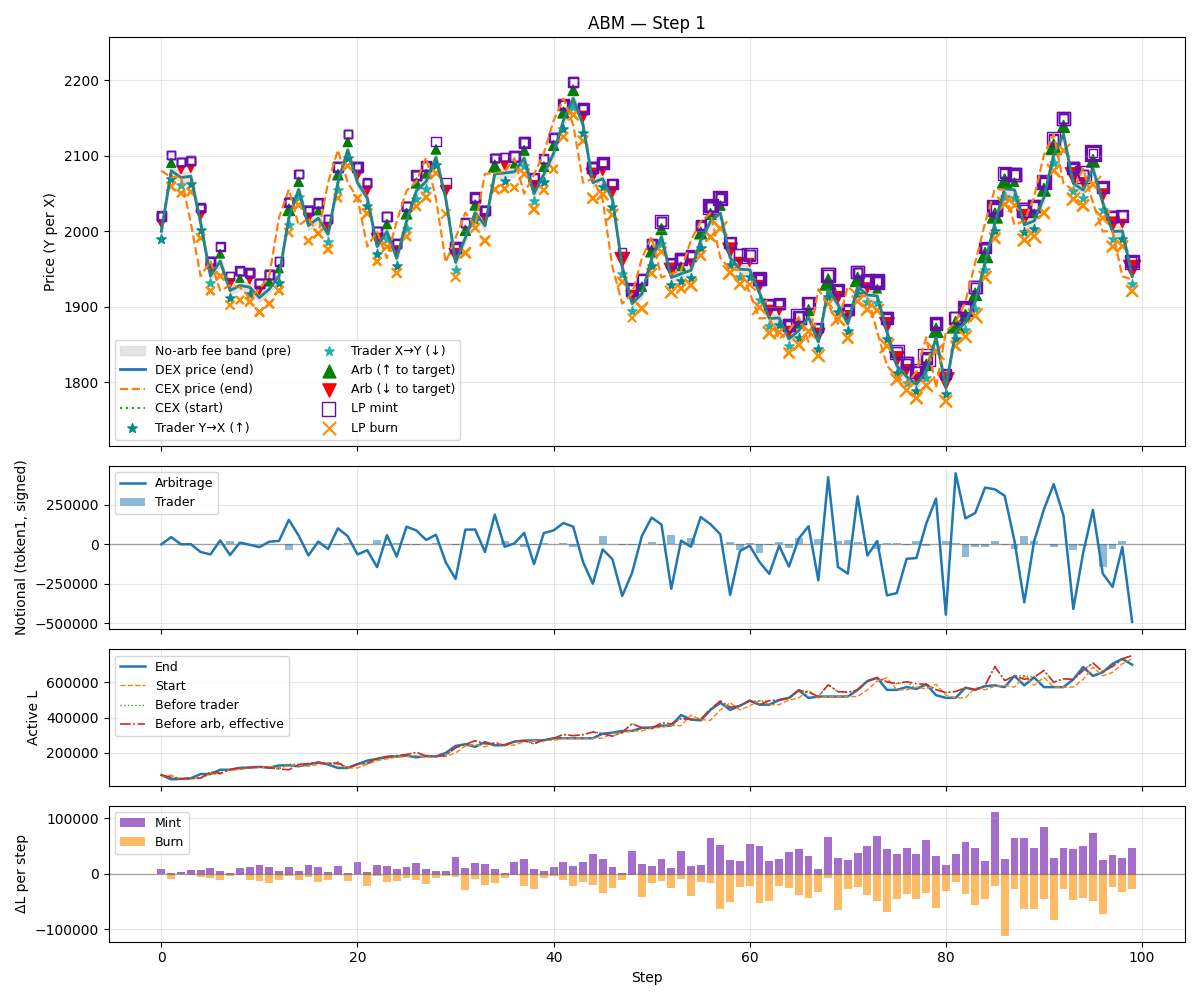

In [18]:
"""
ABM Step 1 — Uniswap v3 price dynamics with arbitrage, noise traders, and adaptive LPs
======================================================================================

Purpose
-------
This script implements the *first* step of the ABM for Uniswap v3: a single-pool DEX
with concentrated liquidity, fee-on-input swaps, a reference CEX price, noise traders,
a fast (risk–neutral) arbitrageur, and a simple—but data-driven—LP heuristic for
minting/burning ranges.  Blocks, the mempool, and strategic MEV are **not**
modeled here (they arrive in later steps).  The goal is to reproduce the price
co–evolution P_t (DEX) and m_t (CEX), while making every action and liquidity
transition explicit and auditable.

High-level design choices
-------------------------
• **Pool state** is Uniswap v3–style:
  - S = sqrt(price) so that DEX price is P = S² (Y per X).
  - The tick grid is geometric in S with ratio g (>1). Tick *i* has lower boundary
    s_i = base_s · g^i and upper boundary s_{i+1} = g · s_i.
  - Active liquidity L_active is the cumulative sum over a *liquidity_net* map:
    liquidity_net[k] = ΔL when crossing **upward** through boundary k.
    The current active tick is `pool.tick`; L_active depends on `tick`.

• **Fee model**: A constant pool fee *f* is charged **on input**; r ≡ 1–f is the
  retained fraction used to move S.  Fees are accrued to LPs pro-rata by **L**
  in the active tick at the instant of fill.

• **Trades only move price if liquidity exists.**
  If L_active == 0 (a “desert”), both the noise trader and arbitrageur are inert:
  they cannot move S or consume any amount.  The only way to revive the pool in
  a desert is via an LP mint; when that happens the pool **re-anchors** (see below).

• **Arbitrage target**: either the no-arb fee band [m_t·r, m_t/r] (default) or
  parity m_t.  The arbitrageur walks S tick-by-tick **through non-empty ranges**
  until the target is hit or a desert is encountered. No “teleporting” across
  empty regions is allowed in Step 1.

• **Reference market (CEX)**: m_t follows geometric Brownian motion (μ, σ) with a
  **signed** linear impact from the DEX arbitrage notional (token1 units).  Positive
  signed notional (Y→X on the DEX) nudges m *up*; negative nudges m *down*.

• **LP heuristic (Section 4.2 sketch)**:
  - At each step, LPs first **burn** any position whose P&L (in token1 units) hits
    a take-profit +θ_TP or stop-loss –θ_SL threshold (both relative to the HODL
    inventory value at entry).
  - Then each LP independently **mints** with probability `mintProb`.  The new
    range half-width (in ticks) is:
        w_t = w_min + ψ · (V_arb^(τ)/V_tot^(τ)) + |ε|,
    where ε ~ Binomial(n,p) – n·p introduces discrete noise and
    V_arb^(τ)/V_tot^(τ) is a τ-step informed-flow ratio.
  - The minted liquidity magnitude is L_new = |N(μ,σ)| · max(L_active, 1).
  - **Re-anchor rule**: if L_active==0 *before* a mint, the pool clamps S into the
    minted range [s_a, s_b] (to its geometric mid √(s_a·s_b) if outside) and
    recomputes `tick` and L_active.  This is the **only** mechanism that moves the
    DEX price inside deserts.

Event order within a step t
---------------------------
(1) **Record pre-state:** store P_{t-1}, m_{t-1}, the **pre-step fee band**
    [m_{t-1}·r, m_{t-1}/r], and L_active (start-of-step).

(2) **LPs adjust:**
    • Burn positions whose P&L breaches ±θ thresholds.
    • Possibly mint a new centered range with width w_t computed from the informed
      flow proxy.  If the book was empty, re-anchor into the minted range.

(3) **Noise trader (optional):**
    With probability p_trade and only if L_active>0:
    • Side is uniformly random in {X→Y, Y→X}.
    • Size is lognormal scaled by active liquidity:
        dx_scale ≈ α_x · L_active / S,   dy_scale ≈ α_y · L_active · S.
    • An exact v3 swap integrates S within the tick and crosses one tick at a time.
      Fees on input are computed as:
        input_eff = input_pre · r;   fee = input_pre − input_eff.
    • **Signed notional (token1 units):**
        - X→Y (price ↓):   trader_Y = − P_pre · dx_used_pre_fee.
        - Y→X (price ↑):   trader_Y = + dy_used_pre_fee.
    • Fees are distributed pro-rata by **L** in the active tick snapshot.

(4) **Arbitrageur:**
    Only if L_active>0:
    • Target price is the band edge or parity.
    • A fast, tick-aware integrator moves S within a span and then crosses to the
      next tick, stopping if the target is hit or a desert is encountered.
    • We record `L_first_fill`: the active liquidity at the instant of the first
      non-zero consumption (after any crossings).  This is used by invariants.
    • **Signed notional (token1 units):**
        - Direction “up” (Y→X on DEX, price ↑):  arb_Y = + dy_used_pre_fee.
        - Direction “down” (X→Y on DEX, price ↓): arb_Y = − P_pre · dx_used_pre_fee.
    • Swap fees are allocated exactly like for the trader, using the pre-fill
      tick snapshot and `L_first_fill`.

(5) **CEX update (m_t):**
    m_t = m_{t-1} · exp(μ − ½σ² + σZ_t) · (1 + κ · clamp(arb_Y, −1, +1)),
    where `arb_Y` is the **signed** DEX arbitrage notional in token1 units.

(6) **Record post-state:** store P_t, m_t, the **post-step fee band** [m_t·r,m_t/r],
    and `L_active` (end-of-step).  All plotting series and markers are updated here.

Mechanics and formulas (v3 within-tick)
---------------------------------------
Let S be the current sqrt-price and L the active liquidity in the tick.

• **Y→X (price up)** to S' ≤ s_upper:
    dy_eff = L · (S' − S)
    dy_pre = dy_eff / r
    dx_out = L · (1/S − 1/S')
    fee_y  = dy_pre − dy_eff
  If S' reaches s_upper exactly and more input remains, the swap crosses one tick up,
  updating `tick` and L_active by adding liquidity_net[tick+1].

• **X→Y (price down)** to S' ≥ s_lower:
    dx_eff = L · (1/S' − 1/S)
    dx_pre = dx_eff / r
    dy_out = L · (S − S')
    fee_x  = dx_pre − dx_eff
  Crosses one tick down by subtracting liquidity_net[tick] from L_active.

The noise trader path uses the **exact** integrator above; the arbitrageur uses a
“fast” version that integrates a full span in one shot, but still crosses ticks
sequentially.  In both cases, consumption halts at deserts (L_active==0).

Liquidity providers (positions and P&L)
---------------------------------------
Each LP position stores:
  • Tick range [lower, upper), liquidity L, and the corresponding price bounds
    (s_a, s_b) = (s_lower(lower), s_lower(upper)).
  • Entry inventories (amt0_init, amt1_init) and their HODL value in token1 units
    at entry: hodl0_value_y = amt0_init·m_entry + amt1_init.
  • Accrued fees (fees0 in token0, fees1 in token1).

At time t, with current S and m:
  - Position inventory (token0, token1) is
        (L·(1/S − 1/s_b),  L·(S − s_a)) if s_a < S < s_b,
        (L·(1/s_a − 1/s_b), 0) if S ≤ s_a, and
        (0, L·(s_b − s_a)) if S ≥ s_b.
  - Instant value in token1:  val_y = token0·m + token1.
  - Impermanent loss IL_y = val_y − hodl0_value_y.
  - P&L_y = IL_y + (fees0·m + fees1).

The LP heuristic burns positions when P&L_y ≥ +θ_TP·hodl0_value_y or
P&L_y ≤ −θ_SL·hodl0_value_y.  Minted ranges are centered at the current tick with
half-width w_t (in ticks) given above.

“Re-anchor” rule and deserts
----------------------------
If the pool is empty (L_active==0) and an LP mints a range [s_a, s_b], the pool
re-anchors:
  1) If the current S ∉ [s_a, s_b], set S := √(s_a·s_b) (geometric mid).
  2) Recompute `tick` from S and **rebuild** L_active by summing liquidity_net.
This is the **only** way S can change in a desert; traders and arbitrageurs never
move S when L_active==0.

Signed notional conventions (token1 / Y units)
----------------------------------------------
• Trader:
  - X→Y: negative (selling X for Y, puts **downward** pressure on price)
          trader_Y = − P_pre · dx_used_pre_fee
  - Y→X: positive (buying X with Y, **upward** pressure)
          trader_Y = + dy_used_pre_fee

• Arbitrage:
  - “up” leg (Y→X):       arb_Y = + dy_used_pre_fee
  - “down” leg (X→Y):     arb_Y = − P_pre · dx_used_pre_fee

These signs are also used to impact the CEX.

Recorded series and markers
---------------------------
• Prices: P_t (DEX), m_t (CEX).
• Fee bands: pre-step [m_{t-1}·r, m_{t-1}/r] (dotted) and post-step [m_t·r, m_t/r]
  (shaded).
• Liquidity: L_active at start of step, before trader, **before arbitrage (effective
  first-fill L)**, and at end of step.
• Flow series (token1, signed): trader_Y[t], arb_Y[t].
• Markers:
  - Trader fills: teal star below P_t (down) or above P_t (up).
  - Arbitrage fills: green (up) / red (down) triangles above P_t, size ∝ |arb_Y|.
  - LP mints: purple empty squares above P_t; annotation shows +ΔL when large.
  - LP burns: orange “x” below P_t; annotation shows –ΔL when large.
• Visual guardrails: steps that **end** with L_active≈0 are lightly shaded red in the
  liquidity panel.

Invariants (runtime assertions)
-------------------------------
The script fails fast if any of the following is violated:
1) A trader or arbitrage **fill** occurs while effective L==0.
   (For arbitrage this uses `L_first_fill` after tick crossings.)
2) The DEX price changes materially within a step but **no** fill happened and
   **no** LP ΔL (mint/burn) occurred in that step.

These invariants guarantee a consistent causal link between markers, notionals, and
liquidity evolution.

Parameters (typical)
--------------------
• Pool: fee f (e.g., 0.003), tick ratio g (e.g., 1.0001), initial price m₀ and
  base_s chosen so that S₀ lies mid-tick 0.  The initial liquidity book is a symmetric
  “hill” of nested ranges (several ΔL at different widths).
• Trader: p_trade, size scales (α_x, α_y) for X and Y legs, lognormal size.
• Arbitrage: target=fee band (default) or parity; exact tick traversal.
• CEX: (μ, σ, κ), with **signed** impact of arb_Y on m_t.
• LP heuristic: τ, w_min, ψ, (n,p) for binomial noise, mint magnitude (μ,σ),
  thresholds θ_TP, θ_SL, per-LP mint probability.

Outputs and plots
-----------------
Four aligned panels:
  (i)  Price panel with pre/post bands and action markers.
  (ii) Signed notionals (bars for trader, line for arbitrage).
  (iii) Active liquidity traces (start, before trader, **before arb (effective)**,
       end), with red shading on steps that end with zero liquidity.
  (iv) Per-step ΔL histogram (mint positive, burn negative).

Complexity and data structures
------------------------------
Within a step, swaps are O(#tick-spans crossed).  A small boundary index stores
non-zero entries of `liquidity_net` and provides O(log B) lookup of the next
boundary when crossing ticks.  Mint/burn operations update `liquidity_net`
in O(1) and mark the index dirty.

Scope and limitations
---------------------
This is **Step 1**.  There is no mempool, no block auction, and no strategic MEV
searcher.  Liquidity is static *within* a step (no re-quoting mid-fill).  The fee
is constant; gas, slippage tolerance, and offchain latency are ignored.  These
abstractions are lifted in subsequent steps when we introduce discrete blocks,
pending order visibility, and MEV strategies (sandwich, JIT, JIT+sandwich, and
reverse-trade arbitrage).

Reproducibility
---------------
Set the RNG seed at the top of `simulate()` for deterministic runs.  All actions,
sizes, and state paths are recorded and plotted; invariants will raise exceptions
if a causal inconsistency is introduced by future edits.

"""


from __future__ import annotations
import math, random
from dataclasses import dataclass, field
from typing import Dict, Tuple, List, Optional
from collections import deque
from bisect import bisect_right, bisect_left

import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt


# ------------------ Utilities ------------------

def clamp(x, lo, hi): return max(lo, min(hi, x))


# ------------------ Pool ------------------

@dataclass
class V3Pool:
    g: float
    base_s: float
    tick: int
    S: float
    f: float
    liquidity_net: Dict[int, float] = field(default_factory=dict)
    L_active: float = 0.0

    def __post_init__(self): self.recompute_active_L()

    def recompute_active_L(self):
        L = 0.0
        for t, dL in self.liquidity_net.items():
            if t <= self.tick: L += dL
        self.L_active = L

    def s_lower(self, i: Optional[int] = None) -> float:
        if i is None: i = self.tick
        return self.base_s * (self.g ** i)

    def s_upper(self, i: Optional[int] = None) -> float:
        return self.s_lower(i) * self.g

    @property
    def r(self) -> float: return 1.0 - self.f
    @property
    def price(self) -> float: return self.S * self.S

    def add_liquidity_range(self, lower_tick: int, upper_tick: int, L: float):
        assert lower_tick < upper_tick
        self.liquidity_net[lower_tick] = self.liquidity_net.get(lower_tick, 0.0) + L
        self.liquidity_net[upper_tick] = self.liquidity_net.get(upper_tick, 0.0) - L
        if lower_tick <= self.tick: self.L_active += L
        if upper_tick <= self.tick: self.L_active -= L

    # One-tick crosses (used by the trader’s exact path)
    def _cross_up_once(self):
        self.tick += 1
        self.L_active += self.liquidity_net.get(self.tick, 0.0)

    def _cross_down_once(self):
        self.L_active -= self.liquidity_net.get(self.tick, 0.0)
        self.tick -= 1

    # Exact swaps for the noise trader
    def swap_x_to_y(self, dx_in: float) -> Tuple[float, float, float]:
        if dx_in <= 0 or self.L_active <= 0: return 0.0, 0.0, 0.0
        dx_eff = dx_in * self.r; dx_used=0.0; dy_out=0.0
        while dx_eff > 1e-18 and self.L_active > 0:
            S_lo = self.s_lower()
            if self.S <= S_lo + 1e-18:
                self.S = S_lo; self._cross_down_once(); continue
            dx_to = self.L_active * (1/S_lo - 1/self.S)
            if dx_eff < dx_to - 1e-18:
                S_new = 1/(1/self.S + dx_eff/self.L_active)
                dy = self.L_active * (S_new - self.S)       # negative
                self.S = S_new; dx_used += dx_eff; dy_out += -dy; dx_eff = 0.0
            else:
                dy = self.L_active * (S_lo - self.S)        # negative
                self.S = S_lo; dx_eff -= dx_to; dx_used += dx_to; dy_out += -dy
                self._cross_down_once()
        dx_pre = dx_used / self.r if self.r>0 else dx_used
        fee_x = dx_pre - dx_used
        return dx_pre, dy_out, fee_x

    def swap_y_to_x(self, dy_in: float) -> Tuple[float, float, float]:
        if dy_in <= 0 or self.L_active <= 0: return 0.0, 0.0, 0.0
        dy_eff = dy_in * self.r; dy_used=0.0; dx_out=0.0
        while dy_eff > 1e-18 and self.L_active > 0:
            S_hi = self.s_upper()
            if self.S >= S_hi - 1e-18:
                self.S = S_hi; self._cross_up_once(); continue
            dy_to = self.L_active * (S_hi - self.S)
            if dy_eff < dy_to - 1e-18:
                S_new = self.S + dy_eff/self.L_active
                dx = self.L_active * (1/self.S - 1/S_new)
                self.S = S_new; dy_used += dy_eff; dx_out += dx; dy_eff = 0.0
            else:
                dx = self.L_active * (1/self.S - 1/S_hi)
                self.S = S_hi; dy_eff -= dy_to; dy_used += dy_to; dx_out += dx
                self._cross_up_once()
        dy_pre = dy_used / self.r if self.r>0 else dy_used
        fee_y = dy_pre - dy_used
        return dy_pre, dx_out, fee_y


# ------------------ Boundary index ------------------

class BoundaryIndex:
    def __init__(self, liquidity_net: Dict[int,float]):
        self.liq = liquidity_net
        self.keys = sorted([k for k,v in liquidity_net.items() if abs(v)>1e-18])
        self.dirty=False
    def mark_dirty(self): self.dirty=True
    def _ensure(self):
        if self.dirty:
            self.keys = sorted([k for k,v in self.liq.items() if abs(v)>1e-18])
            self.dirty=False
    def next_up(self, tick:int)->Optional[int]:
        self._ensure(); i = bisect_right(self.keys, tick)
        return self.keys[i] if i < len(self.keys) else None
    def prev_down(self, tick:int)->Optional[int]:
        self._ensure(); i = bisect_left(self.keys, tick)-1
        return self.keys[i] if i>=0 else None


# ------------------ LP positions & agents ------------------

@dataclass
class Position:
    owner:int; lower:int; upper:int; L:float; sa:float; sb:float
    amt0_init:float; amt1_init:float
    fees0:float=0.0; fees1:float=0.0; hodl0_value_y:float=0.0
    def in_range(self, tick:int)->bool: return self.lower <= tick < self.upper
    def current_amounts(self, S:float)->Tuple[float,float]:
        if S <= self.sa: return (self.L*(1/self.sa-1/self.sb), 0.0)
        if S >= self.sb: return (0.0, self.L*(self.sb-self.sa))
        return (self.L*(1/S-1/self.sb), self.L*(S-self.sa))
    def hodl_value_y_now(self, m:float)->float: return self.amt0_init*m + self.amt1_init
    def position_value_y_now(self, S:float, m:float)->float:
        a0,a1 = self.current_amounts(S); return a0*m + a1
    def fees_value_y(self, m:float)->float: return self.fees0*m + self.fees1
    def IL_y(self, S:float, m:float)->float: return self.position_value_y_now(S,m) - self.hodl0_value_y
    def PnL_y(self, S:float, m:float)->float: return self.IL_y(S,m) + self.fees_value_y(m)

@dataclass
class LPAgent:
    id:int; positions:List[Position]=field(default_factory=list)
    mintProb:float=0.5


# ------------------ Reference market ------------------

@dataclass
class ReferenceMarket:
    m: float; mu: float; sigma: float; kappa: float
    def step(self, arb_notional_y_signed: float):
        z = np.random.normal()
        self.m *= math.exp(self.mu - 0.5*self.sigma**2 + self.sigma*z)
        self.m *= (1.0 + clamp(arb_notional_y_signed, -1.0, 1.0)*self.kappa)
        self.m = max(1e-12, self.m)


# ------------------ Build pool ------------------

def build_demo_pool()->Tuple[V3Pool,float]:
    f=0.003; g=1.0001; m0=2000.0
    S0 = math.sqrt(m0); base_s = S0/math.sqrt(g)
    pool = V3Pool(g=g, base_s=base_s, tick=0, S=S0, f=f, liquidity_net={})
    def add(width,L): pool.add_liquidity_range(-width,+width,L)
    add(10,5_000.0); add(50,10_000.0); add(150,20_000.0); add(500,30_000.0)
    return pool, m0


# ------------------ Simulation ------------------

def simulate(T:int=120, seed:int=7, verbose_steps:int=8,
             p_trade:float=0.6, N_LP:int=12, tau:int=20,
             w_min_ticks:int=25, psi_ticks:int=300,
             binom_n:int=8, binom_p:float=0.5,
             mint_mu:float=0.01, mint_sigma:float=0.02,
             theta_TP:float=0.003, theta_SL:float=0.01):
    """
    Run Step-1 ABM for a single Uniswap v3 pool with noise traders, a risk-neutral
    arbitrageur, and adaptive LPs (mint/burn heuristic). Produces a 4-panel plot
    (prices + fee band, signed notionals, liquidity traces, per-step ΔL) and
    returns the full time series and event logs.

    Overview
    --------
    Each discrete step t executes in this order:
      (1) Record **pre-step** state and the **pre-step no-arb fee band**
          [m_t·(1−f), m_t/(1−f)] built from the current CEX mid m_t.
      (2) LPs act: burn positions on P&L thresholds; optionally mint a new
          centered range whose half-width (ticks) is
              w_t = w_min + psi * (V_arb^(τ)/V_tot^(τ)) + |Binom(n,p) − n·p|.
          If the book is empty (L_active==0) before a mint, the pool **re-anchors**
          the price S into the minted range (geometric mid) and rebuilds active L.
      (3) Noise trader (with probability p_trade) executes an exact v3 swap
          (fee-on-input) only if L_active>0.
      (4) Arbitrageur moves price toward the **pre-step target**:
          the fee-band edge if `use_fee_band=True`, else CEX parity m_t. The arb
          traverses tick spans with a fast integrator, halting at deserts.
      (5) Update CEX m_{t+1} via GBM with **signed** linear impact from the arb
          notional (token1 units).
      (6) Record **end-of-step** state and update plot series.

    Economics & invariants
    ----------------------
    • Fee model: constant fee f on input, r≡1−f retained to move S.
    • Swaps in deserts: **disabled**. If L_active==0, traders/arbs cannot move price.
      The only in-desert motion is the re-anchor on the first mint.
    • Invariants (raise on violation):
        1) No trader/arb fill when effective liquidity == 0.
        2) If the DEX price changes within a step, then at least one of:
           (i) a trader/arb fill occurred, or (ii) an LP mint/burn happened.

    Parameters
    ----------
    T : int, default 120
        Number of discrete steps.
    seed : int, default 7
        RNG seed (NumPy + Python `random`) for reproducibility.
    verbose_steps : int, default 8
        Print detailed logs for the first `verbose_steps` steps.
    p_trade : float, default 0.6
        Probability that the noise trader submits a swap in a step.
    N_LP : int, default 12
        Number of LP agents using the mint/burn heuristic.
    tau : int, default 20
        Window length for the informed-flow ratio V_arb^(τ)/V_tot^(τ) used in width.
    w_min_ticks : int, default 25
        Baseline half-width (ticks) for newly minted LP ranges.
    psi_ticks : int, default 300
        Sensitivity (ticks) mapping informed flow ratio to added width.
    binom_n : int, default 8
    binom_p : float, default 0.5
        Binomial noise parameters for discrete width jitter.
    mint_mu : float, default 0.01
    mint_sigma : float, default 0.02
        Parameters of |Normal(mint_mu, mint_sigma)| scaling the minted liquidity
        magnitude L_new = scale * max(L_active, 1).
    theta_TP : float, default 0.003
    theta_SL : float, default 0.01
        P&L thresholds (in token1 units, relative to HODL entry value) for
        take-profit and stop-loss burns.

    Returns
    -------
    dict
        A dictionary of NumPy arrays / Python lists with all recorded series:
        Prices & bands
            "DEX_price"     : np.ndarray, end-of-step DEX price P_t (Y per X).
            "CEX_price"     : np.ndarray, end-of-step CEX mid m_t.
            "band_lo_pre"   : np.ndarray, lower edge of **pre-step** fee band m_t·(1−f).
            "band_hi_pre"   : np.ndarray, upper edge of **pre-step** fee band m_t/(1−f).
        Liquidity traces (Uniswap v3 liquidity units)
            "L_active_end"  : np.ndarray, active liquidity at end of step.
            "L_pre_step"    : np.ndarray, active liquidity at start of step.
            "L_pre_trader"  : list/np.ndarray, active liquidity just before the trader.
            "L_pre_arb_eff" : list/np.ndarray, **effective** active liquidity just
                               before the arb’s first non-zero fill (NaN if no fill).
        Flow series (token1 units, signed)
            "trader_notional_y" : list[float], trader per-step signed input (Y).
            "arb_notional_y"    : list[float], arb per-step signed input (Y).
        Event logs
            "trader_steps"  : list[int], steps with trader fills.
            "trader_dirs"   : list[str], "up" (Y→X) or "down" (X→Y) per trader fill.
            "arb_steps"     : list[int], steps with arb fills.
            "arb_dirs"      : list[str], "up" or "down" per arb fill.
        LP events (ΔL in v3 liquidity units)
            "mint_steps"    : list[int], steps with LP mints.
            "mint_sizes"    : list[float], ΔL minted at those steps.
            "burn_steps"    : list[int], steps with LP burns.
            "burn_sizes"    : list[float], ΔL burned at those steps.

    Plot (side effects)
    -------------------
    Produces a 4-panel Matplotlib figure:
      (i)  DEX and CEX prices with **shaded pre-step fee band** (arb target)
           and action markers (trader stars; arb triangles sized by |arb notional|;
           LP mints squares; LP burns ×).
      (ii) Signed notionals (trader bars, arb line).
      (iii) Active liquidity traces (start, before trader, **before arb (effective)**, end).
            Steps ending with L_active≈0 are lightly shaded red as guardrails.
      (iv) Per-step LP ΔL histogram (mint positive, burn negative).

    Units & signs
    -------------
    • Price P_t in Y per X; CEX mid m_t in Y per X.
    • Notionals are in token1 (Y). Positive = Y→X (price ↑); negative = X→Y (price ↓).
    • Liquidity L is in Uniswap v3 “liquidity units” (not reserves).

    Exceptions
    ----------
    AssertionError
        If any trader/arb fill occurs when effective L==0 (desert).
    RuntimeError
        If the DEX price changes within a step without any fill and without any LP ΔL
        in that step (causality violation).

    Notes
    -----
    • The noise trader uses the **exact** within-tick integrator and crosses ticks
      one at a time; the arbitrageur uses a mathematically equivalent **span**
      integrator (conserves amounts/fees) to traverse tick spans efficiently.
    • Complexity is O(#tick-spans crossed per step); the boundary index accelerates
      locating the next non-zero ΔL boundary after mint/burn updates.
    """

    np.random.seed(seed); random.seed(seed)

    pool, m0 = build_demo_pool()
    bidx = BoundaryIndex(pool.liquidity_net)
    ref  = ReferenceMarket(m=m0, mu=0.0, sigma=0.02, kappa=1e-3)
    LPs  = [LPAgent(id=i, mintProb=0.5) for i in range(N_LP)]

    size_scale_x = 0.005; size_scale_y = 0.005
    arb_abs_win = deque(maxlen=tau); tot_abs_win = deque(maxlen=tau)

    # Recorders
    P_series=[]; M_series=[]; M_pre = []
    band_lo_pre=[]; band_hi_pre=[]
    L_end=[]; L_pre_step=[]; L_pre_trader=[]; L_pre_arb_eff=[]
    trader_y_series=[]; arb_y_series=[]
    trader_steps=[]; trader_dirs=[]; arb_steps=[]; arb_dirs=[]
    mint_steps=[]; mint_sizes=[]; burn_steps=[]; burn_sizes=[]

    # --- Fee allocation helper
    def allocate_fees(token:str, fee_amt:float, tick_snapshot:int, L_snapshot:float):
        if fee_amt<=0 or L_snapshot<=0: return
        for lp in LPs:
            for pos in lp.positions:
                if pos.in_range(tick_snapshot):
                    share = pos.L / L_snapshot
                    if token=='x': pos.fees0 += share*fee_amt
                    else:          pos.fees1 += share*fee_amt

    # --- Re-anchor on first mint when book is empty
    def reanchor_on_first_liquidity(sa:float, sb:float):
        # If current S not in [sa,sb], move to geometric mid of the range.
        if not (sa <= pool.S <= sb):
            pool.S = math.sqrt(sa*sb)
        # Clamp tick to this S and recompute L
        pool.tick = int(math.floor(math.log(max(pool.S,1e-18)/pool.base_s, pool.g)))
        pool.recompute_active_L()

    # --- LP ops
    def mint_lp(lp:LPAgent, width_ticks:int):
        X = abs(np.random.normal(mint_mu, mint_sigma))
        L_new = X * max(pool.L_active, 1.0)
        lower, upper = pool.tick - width_ticks, pool.tick + width_ticks
        sa, sb = pool.s_lower(lower), pool.s_lower(upper)
        amt0 = L_new*(1/sa - 1/sb); amt1 = L_new*(sb - sa)
        pos = Position(owner=lp.id, lower=lower, upper=upper, L=L_new,
                       sa=sa, sb=sb, amt0_init=amt0, amt1_init=amt1,
                       hodl0_value_y=amt0*ref.m + amt1)
        pool.add_liquidity_range(lower, upper, L_new); bidx.mark_dirty()
        lp.positions.append(pos)
        # If book is empty before this mint, re-anchor into the minted range
        if pool.L_active <= 1e-18:
            reanchor_on_first_liquidity(sa, sb)
        mint_steps.append(t); mint_sizes.append(L_new)
        if t < verbose_steps:
            print(f"[t={t:03d}] LP{lp.id} MINT L={L_new:.1f} [{lower},{upper}) | L_active={pool.L_active:.1f}")

    def burn_any(lp:LPAgent, idx:int):
        pos = lp.positions.pop(idx)
        pool.add_liquidity_range(pos.lower, pos.upper, -pos.L); bidx.mark_dirty()
        burn_steps.append(t); burn_sizes.append(pos.L)
        if t < verbose_steps:
            print(f"[t={t:03d}] LP{lp.id} BURN L={pos.L:.1f} [{pos.lower},{pos.upper}) | L_active={pool.L_active:.1f}")

    # --- Arbitrage fast path (NO empty-jumps; freeze price in deserts)
    def tick_from_S(S:float)->int:
        return int(math.floor(math.log(max(S,1e-18)/pool.base_s, pool.g)))

    def fast_span_up(to_S:float, target_S:float)->Tuple[float,float,float]:
        S0=pool.S; L=pool.L_active; r=pool.r; S1=min(to_S,target_S)
        if S1 <= S0 or L<=0: return 0.0,0.0,0.0
        dy_eff=L*(S1-S0); dy_pre=dy_eff/r; dx_out=L*(1/S0-1/S1); fee_y=dy_pre-dy_eff
        pool.S=S1; pool.tick=tick_from_S(pool.S); return dy_pre,dx_out,fee_y

    def fast_span_down(to_S:float, target_S:float)->Tuple[float,float,float]:
        S0=pool.S; L=pool.L_active; r=pool.r; S1=max(to_S,target_S)
        if S1 >= S0 or L<=0: return 0.0,0.0,0.0
        dx_eff=L*(1/S1-1/S0); dx_pre=dx_eff/r; dy_out=L*(S0-S1); fee_x=dx_pre-dx_eff
        pool.S=S1; pool.tick=tick_from_S(pool.S); return dx_pre,dy_out,fee_x

    def swap_exact_to_target(target_price:float, direction:str)->Tuple[float,float,float,float,float]:
        # If there is no active liquidity, do nothing (freeze in deserts)
        if pool.L_active <= 1e-18:
            return 0.0,0.0,0.0,0.0,0.0
        target_S = math.sqrt(max(1e-18, target_price))
        total_in=total_out=fee_x=fee_y=0.0; L_first=0.0; eps=1e-12
        if direction=='up':
            while pool.L_active>0 and pool.S<target_S-eps:
                S_hi=pool.s_upper(); L_before=pool.L_active
                dy,dx,f = fast_span_up(S_hi, target_S)
                if dy>0 and L_first==0.0: L_first=L_before
                fee_y += f; total_in += dy; total_out += dx
                if pool.S >= target_S-eps: break
                # cross to next tick
                pool.tick += 1; pool.L_active += pool.liquidity_net.get(pool.tick,0.0)
                if pool.L_active<=0: break     # stop at desert
            return total_in,total_out,fee_x,fee_y,L_first
        else:
            while pool.L_active>0 and pool.S>target_S+eps:
                S_lo=pool.s_lower(); L_before=pool.L_active
                dx,dy,f = fast_span_down(S_lo, target_S)
                if dx>0 and L_first==0.0: L_first=L_before
                fee_x += f; total_in += dx; total_out += dy
                if pool.S <= target_S+eps: break
                pool.L_active -= pool.liquidity_net.get(pool.tick,0.0); pool.tick -= 1
                if pool.L_active<=0: break     # stop at desert
            return total_in,total_out,fee_x,fee_y,L_first

    def arbitrage_to_target()->Tuple[float,Optional[str],float,float,float]:
        P=pool.price; r=pool.r
        if pool.L_active <= 1e-18: return 0.0, None, 0.0, 0.0, 0.0
        # if use_fee_band:
        #     lo,hi = ref.m*r, ref.m/r
        #     if P < lo*(1-1e-9):
        #         used,_,fx,fy,Lff = swap_exact_to_target(lo,'up'); return used,('up' if used>0 else None),fx,fy,Lff
        #     if P > hi*(1+1e-9):
        #         used,_,fx,fy,Lff = swap_exact_to_target(hi,'down'); return used,('down' if used>0 else None),fx,fy,Lff
        #     return 0.0,None,0.0,0.0,0.0
        # else:
        if abs(P-ref.m)/max(ref.m,1e-12) < 1e-9: return 0.0,None,0.0,0.0,0.0
        direction = 'up' if P<ref.m else 'down'
        used,_,fx,fy,Lff = swap_exact_to_target(ref.m,direction)
        return used,(direction if used>0 else None),fx,fy,Lff

    # --------------- Main loop ---------------
    price_change_eps = 1e-10

    for t in range(T):
        r = pool.r
        band_lo_pre.append(ref.m*r); band_hi_pre.append(ref.m/r)
        L_pre_step.append(pool.L_active)
        M_pre.append(ref.m)
        P_before = pool.price

        # LP heuristic width
        V_arb_tau=sum(arb_abs_win) if arb_abs_win else 0.0
        V_tot_tau=sum(tot_abs_win) if tot_abs_win else 1e-12
        informed_ratio = V_arb_tau/max(V_tot_tau,1e-12)
        eps_noise = np.random.binomial(binom_n,binom_p) - binom_n*binom_p
        w_ticks = int(round(w_min_ticks + psi_ticks*informed_ratio + abs(eps_noise)))

        # burns then mints
        for lp in LPs:
            to_burn=[]
            for i,pos in enumerate(lp.positions):
                pnl = pos.PnL_y(pool.S, ref.m)
                if pnl >= theta_TP*pos.hodl0_value_y or pnl <= -theta_SL*pos.hodl0_value_y:
                    to_burn.append(i)
            for i in reversed(to_burn): burn_any(lp,i)
            if random.random() < lp.mintProb: mint_lp(lp,w_ticks)

        # Trader
        P_pre_trader = pool.price
        trader_y = 0.0
        L_pre_trader.append(pool.L_active)
        if random.random() < p_trade and pool.L_active > 0:
            side = random.choice(['X_to_Y','Y_to_X'])
            clip_x = 0.005*pool.L_active/max(1e-12,pool.S)
            clip_y = 0.005*pool.L_active*pool.S
            tick_snap = pool.tick; L_snap = pool.L_active
            if side=='X_to_Y':
                dx = abs(np.random.lognormal(mean=-2.0, sigma=1.0))*clip_x
                used,_,fee_x = pool.swap_x_to_y(dx) if dx>0 else (0.0,0.0,0.0)
                if used>0:
                    assert L_snap>0, f"Trader X→Y fill with L=0 at t={t}"
                    trader_steps.append(t); trader_dirs.append('down')
                    trader_y = - P_pre_trader*used; allocate_fees('x',fee_x,tick_snap,L_snap)
            else:
                dy = abs(np.random.lognormal(mean=-2.0, sigma=1.0))*clip_y
                used,_,fee_y = pool.swap_y_to_x(dy) if dy>0 else (0.0,0.0,0.0)
                if used>0:
                    assert L_snap>0, f"Trader Y→X fill with L=0 at t={t}"
                    trader_steps.append(t); trader_dirs.append('up')
                    trader_y = + used; allocate_fees('y',fee_y,tick_snap,L_snap)
        trader_y_series.append(trader_y)

        # Arbitrage
        P_pre_arb = pool.price
        used_arb, dir_arb, fee_x_arb, fee_y_arb, L_first = arbitrage_to_target()
        arb_y = 0.0
        if used_arb>0 and dir_arb is not None:
            assert L_first>0, f"Arb fill with L=0 at t={t}"
            L_pre_arb_eff.append(L_first)
            arb_steps.append(t); arb_dirs.append(dir_arb)
            arb_y = +used_arb if dir_arb=='up' else - P_pre_arb*used_arb
            if dir_arb=='up' and fee_y_arb>0: allocate_fees('y',fee_y_arb, pool.tick, L_first)
            if dir_arb=='down' and fee_x_arb>0: allocate_fees('x',fee_x_arb, pool.tick, L_first)
        else:
            L_pre_arb_eff.append(np.nan)
        arb_y_series.append(arb_y)

        # Windows for heuristic width
        arb_abs_win.append(abs(arb_y)); tot_abs_win.append(abs(arb_y)+abs(trader_y))

        # CEX update (SIGNED impact)
        ref.step(arb_y)

        # Record end-of-step & invariants
        P_after = pool.price
        P_series.append(P_after); M_series.append(ref.m)
        L_end.append(pool.L_active)

        # Invariant: if price changed materially, something happened (fills or ΔL)
        price_moved = abs(P_after - P_before) > price_change_eps
        had_fill = (abs(trader_y) > 0) or (abs(arb_y) > 0)
        had_L_event = (t in mint_steps) or (t in burn_steps)
        if price_moved and not (had_fill or had_L_event):
            raise RuntimeError(f"DEX price changed at t={t} without fills or LP ΔL. "
                               f"L_active={pool.L_active:.4f}")

        if t < verbose_steps:
            print(f"[t={t:03d}] DEX={pool.price:.4f} | CEX={ref.m:.4f} | "
                  f"traderY={trader_y:.2f} | arb_dir={dir_arb} arbY={arb_y:.2f} | L={pool.L_active:.1f}")

    # ------------------ Plotting ------------------
    P_series=np.array(P_series); M_series=np.array(M_series)
    band_lo_pre=np.array(band_lo_pre); band_hi_pre=np.array(band_hi_pre)
    L_end=np.array(L_end); L_pre_step=np.array(L_pre_step)
    L_pre_trader=np.array(L_pre_trader+[np.nan]*(len(P_series)-len(L_pre_trader)))
    L_pre_arb_eff=np.array(L_pre_arb_eff+[np.nan]*(len(P_series)-len(L_pre_arb_eff)))
    steps=np.arange(len(P_series))

    # ΔL per step (sum)
    mint_step_sum=np.zeros_like(P_series); 
    for s,L in zip(mint_steps,mint_sizes):
        if 0<=s<len(mint_step_sum): mint_step_sum[s]+=L
    burn_step_sum=np.zeros_like(P_series);
    for s,L in zip(burn_steps,burn_sizes):
        if 0<=s<len(burn_step_sum): burn_step_sum[s]+=L

    fig,(ax1,ax2,ax3,ax4)=plt.subplots(4,1,figsize=(12,10),sharex=True,
        gridspec_kw={"height_ratios":[3,1.2,1,1]})

    # Offsets & sizes
    off = (50/1e4)*P_series

    # --- Top: prices + pre band only ---
    ax1.fill_between(
        steps, band_lo_pre, band_hi_pre,
        color="lightgray", alpha=0.6, label="No-arb fee band (pre)"
    )
    ax1.plot(steps, P_series, label="DEX price (end)", linewidth=2)
    ax1.plot(steps, M_series, "--", label="CEX price (end)", linewidth=1.6)
    ax1.plot(steps, M_pre, ":", label="CEX (start)", linewidth=1.6)

    # Trader markers
    t_up=[s for s,d in zip(trader_steps,trader_dirs) if d=='up']
    t_dn=[s for s,d in zip(trader_steps,trader_dirs) if d=='down']
    if t_up: ax1.scatter(t_up, P_series[t_up]-off[t_up], marker='*', color='#008B8B', s=50, label='Trader Y→X (↑)')
    if t_dn: ax1.scatter(t_dn, P_series[t_dn]-off[t_dn], marker='*', color='#20B2AA', s=50, label='Trader X→Y (↓)')

    # Arb markers
    if len(arb_steps)>0:
        arb_abs=np.array([abs(arb_y_series[s]) for s in arb_steps])
        max_abs=float(max(1e-12, np.max(arb_abs))); size=lambda a: 30+120*(a/max_abs)
        up=[s for s,d in zip(arb_steps,arb_dirs) if d=='up']
        dn=[s for s,d in zip(arb_steps,arb_dirs) if d=='down']
        if up: ax1.scatter(up, P_series[up]+off[up], marker='^', color='green',
                           s=[size(abs(arb_y_series[s])) for s in up], label='Arb (↑ to target)')
        if dn: ax1.scatter(dn, P_series[dn]+off[dn], marker='v', color='red',
                           s=[size(abs(arb_y_series[s])) for s in dn], label='Arb (↓ to target)')

    # LP markers (show big ones with labels)
    if len(mint_steps)+len(burn_steps)>0:
        maxL=1e-12
        if mint_sizes: maxL=max(maxL,max(mint_sizes))
        if burn_sizes: maxL=max(maxL,max(burn_sizes))
        scaleL=lambda L: 30+120*(L/maxL); label_thr=0.25*maxL
        if mint_steps:
            ax1.scatter(mint_steps, P_series[mint_steps]+2*off[mint_steps],
                        marker='s', facecolors='none', edgecolors='#6a0dad',
                        s=[scaleL(L) for L in mint_sizes], label='LP mint')
            # for s,L in zip(mint_steps,mint_sizes):
            #     if L>=label_thr:
            #         ax1.annotate(f"+{L:.0f}", (s, P_series[s]+2*off[s]), textcoords="offset points",
            #                      xytext=(0,6), ha="center", fontsize=7, color="#6a0dad")
        if burn_steps:
            ax1.scatter(burn_steps, P_series[burn_steps]-2*off[burn_steps],
                        marker='x', color='#ff8c00',
                        s=[scaleL(L) for L in burn_sizes], label='LP burn')
            # for s,L in zip(burn_steps,burn_sizes):
            #     if L>=label_thr:
            #         ax1.annotate(f"-{L:.0f}", (s, P_series[s]-2*off[s]), textcoords="offset points",
            #                      xytext=(0,-10), ha="center", fontsize=7, color="#ff8c00")

    ax1.set_ylabel("Price (Y per X)"); ax1.set_title("ABM — Step 1")
    ax1.grid(True, alpha=0.3); ax1.legend(ncol=2, fontsize=9); ax1.margins(y=0.14)

    # Notionals
    trader_y=np.array(trader_y_series); arb_y=np.array(arb_y_series)
    ax2.axhline(0.0, color='k', lw=1.0, alpha=0.3)
    ax2.bar(steps, trader_y, width=0.8, alpha=0.5, label="Trader")
    ax2.plot(steps, arb_y, label="Arbitrage", lw=1.8)
    ax2.set_ylabel("Notional (token1, signed)"); ax2.grid(True, alpha=0.3); ax2.legend(fontsize=9, loc='upper left')

    # Liquidity (multi-trace)
    ax3.plot(steps, L_end, lw=1.8, label="End")
    ax3.plot(steps, L_pre_step, lw=1.0, ls='--', label="Start")
    ax3.plot(steps, L_pre_trader, lw=1.0, ls=':', label="Before trader")
    ax3.plot(steps, L_pre_arb_eff, lw=1.2, ls='-.', label="Before arb, effective")
    ax3.set_ylabel("Active L"); ax3.grid(True, alpha=0.3); ax3.legend(fontsize=9, loc='upper left')

    # Visual guardrails: shade steps ending with zero L
    for s,L in enumerate(L_end):
        if L <= 1e-9: ax3.axvspan(s-0.5, s+0.5, color='red', alpha=0.05, lw=0)

    # ΔL per step
    ax4.axhline(0.0, color='k', lw=1.0, alpha=0.3)
    ax4.bar(steps, mint_step_sum, width=0.8, alpha=0.6, label="Mint", color="#6a0dad")
    ax4.bar(steps, -burn_step_sum, width=0.8, alpha=0.6, label="Burn", color="#ff8c00")
    ax4.set_xlabel("Step"); ax4.set_ylabel("ΔL per step"); ax4.grid(True, alpha=0.3); ax4.legend(fontsize=9, loc='upper left')

    plt.tight_layout(); plt.show()


if __name__ == "__main__":
    simulate(T=100, seed=7, verbose_steps=10,
                p_trade=0.7, N_LP=8, tau=20,
                w_min_ticks=21, psi_ticks=30,
                binom_n=8, binom_p=0.5,
                mint_mu=0.01, mint_sigma=0.02,
                theta_TP=0.003, theta_SL=0.01)
